# 1.关于权重初始化

- 在glorot10a.pdf中作者提出，对于全连接层，如果权重的初始化合理，可以有效提升网络的性能。即Xavier
    - https://pytorch.org/docs/stable/nn.init.html
    - 条件：
        - 在输入数据经过该层之后，输出依旧保持输入的分布
        - 在反向传播的时候，梯度值依旧保持输入的分布
    - 以此为条件对权重进行初始化，即得到Xavier初始化
    - 考虑全连接+激活做为一个整体，那么权重初始化需要考虑输入数据经过linear+sigmoid后的值，是否依旧保持原有分布
    - Xavier初始化公式xavier normal为$(0, std^2)$：$std = gain \times \sqrt{\frac{2}{fan\_in + fan\_out}}$
        - fan_in为输入的数据量，fan_out为输出的数据量
        - Linear中，就是输入通道数和输出通道数
        - Conv中，则需要计算通道与宽高的乘积
    - Xavier考虑的非线性激活函数为：TanH
- 2015年何凯明的研究中，针对激活函数的发展，此时有了Sigmoid、ReLU等一系列情况
    - 凯明初始化kaiming normal$(0, std^2)$：$std = \frac{gain}{\sqrt{fan\_mode}}$
- 对于gain为不同激活层具有不同的增益，即：
    - Linear / Identity:   1
    - Conv{1, 2, 3}D:      1
    - Sigmoid:             1
    - TanH:                $\frac{5}{3}$
    - ReLU:                $\sqrt{2}$
    - Leaky ReLU:          $\sqrt{\frac{2}{1 + negative\_slope^2}}$
    - SELU:                $\frac{3}{4}$

# 2.关于标准化、归一化、正则化

* 归一化（Normalization）
    - 将数据缩放到0-1之间
    - 线性（常用）归一化：最大最小值归一化，$$ y=\frac{x - min(x)}{max(x) - min(x)} $$
    - 其他或者非线性
* 标准化（Standardization）
    - 将数据按比例缩放，使之落入一个小的特定区间
    - z-score方法：去均值除标准差 $$ y=\frac{x - \mu}{\sigma} = \frac{x - np.mean(x)}{np.std(x)} $$
        - 该方法使得数据被标准化到均值为0，方差为1的标准正态分布，非常适合统计学中满足各种条件
        - 而z-score本身也有特定的含义，是一种可以看出某分数在分布中相对位置的方法
        - 对数标准化 $$ y = \frac{1}{1 + e^{-x}} $$
* 正则化（Regularization）
    - 利用先验知识，在处理过程中引入正则化因子(regulator)，增加引导约束的作用
    - 结构风险最小化就是一种正则化手段
    - 很抽象，一般用来对模型做约束
    - L1正则化、L2正则化
    - Dropout正则化方法、weight decay方法

# 3.范数（Norm）
* P范数的定义：$$ ||x||_{p} = \sqrt[p]{\sum_{i=1}^{n}|x_i|^p}$$
* 无穷范数： $$ ||x||_{\infty} = max(x) $$
* L1范数： $$ ||x||_1 = \sum_{i=1}^{n}|x_i| $$
* L2范数： $$ ||x||_2 = \sqrt{\sum_{i=1}^{n}x_{i}^{2}} $$
* 夹角余弦：$cos\theta = \frac{a \cdot b}{||a||_2 \cdot ||b||_2} $

![](p-norm.png)

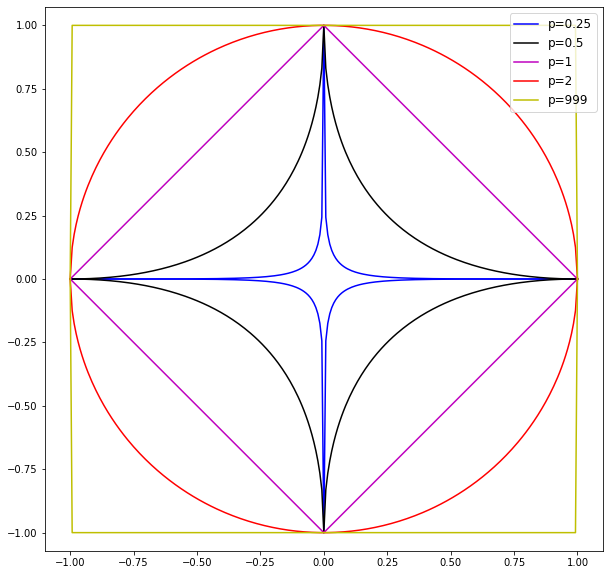

In [1]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
r = 1
style = ["b-", "k-", "m-", "r-", "y-", "g-"]
p_values = 0.25, 0.5, 1, 2, 999
for index, p in enumerate(p_values):
    x = np.arange(-r, r + 1e-5, 1 / 128.0)
    y = (r ** p - (np.abs(x) ** p)) ** (1.0 / p)
    plt.plot(x, y, style[index], label=f"p={p}")
    plt.plot(x, -y, style[index])
    
plt.legend(handles=[], labels=[f"p={p}" for p in p_values], loc='upper right', fontsize="large")
val = plt.axis("equal")

## 4.NN中的数据标准化/归一化
* 常用的，是对数据进行归一化，缩放到-1到+1之间，或者-0.5到+0.5
* 或者减去均值除以标准差

## 5.NN中的正则化/正则化项
* Weight Decay，L2正则化 $$ loss = loss_0 + \frac{\lambda}{2n}\sum_{i=1}^{n}{w_i^2}$$
    - 其中$\lambda$是超参数，为Weight Decay系数，通常很小 1e-5
    - 通过Weight Decay L2正则化后，权重值被作为loss迭代，因此会抑制权重值使得其趋近于0，模型参数趋近于0，等同于降低模型复杂度
    - 对于Adam优化器中使用L2正则化（Weight Decay）时需要注意，如果直接按照SGD的做法，会使得效果并不如意（两者耦合，因为adam的特殊性使得weight decay在其中效果受到不合理的影响），如论文[《DECOUPLED WEIGHT DECAY REGULARIZATION》](https://arxiv.org/pdf/1711.05101.pdf)所说，如[《都9102年了，别再用Adam + L2 regularization了》](https://zhuanlan.zhihu.com/p/63982470)解说
* Dropout，随机失活
    - 通过对输入的参数值乘以采用指定概率的伯努利分布随机数，实现随机将部分值设置为0，同时其导数也会为0，称之为失活
    - 同样是一种模型约束的手段
    - 让网络只看到部分属性依旧能够正常识别的能力

## 6. 权重的初始化
* 如此重要
* 方差一致性原则
    - 每个层，应该尽可能保证输入数据和输出数据的方差一致性
    - 尽量使得每一层的激活避免饱和状态
    - 信号强度度量（采用方差）
    - 方差一致性的结果，是使得信号不会逐层递减，最后消失。反向则是梯度消失的效果
    - 拓展，每个层如果后面对接了激活函数，那么尽量保证经过激活函数后的输出数据与输入方差一致性
* [参数初始化](https://zhuanlan.zhihu.com/p/148034113?from_voters_page=true)
* [参数初始化，凯明初始化](https://zhuanlan.zhihu.com/p/64464584)
* 常量初始化（Constant Initialization），通常是全部初始化为0
    - 意味着将所有计算单元初始化为完全相同的状态，这会使每个计算单元对同一样例的输出和反向更新的梯度存在某种对称关系或甚至完全相同，导致神经网络的灵活性大打折扣
    - 抛弃
* 随机初始化（Random Initialization）
    - 将每个计算单元初始化成不同的状态，但却无法很好选择概率模型中的超参数，例如正态分布$ Normal(\mu, \sigma^2) $中的$\mu$ 和 $\sigma$ ，均匀分布 $Uniform(a, b)$ 中的 $a$ 和 $b$ 。Xavier Initialization和Kaiming Initialization正是为了解决这个问题而提出的
1. 常量初始化
2. 随机初始化，正态分布，均匀分布也罢
3. Xavier初始化 讨论的是tanh，fan_in，fan_out
4. 凯明初始化 讨论的是sigmoid、relu

In [2]:
import struct
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle

读取图片操作

In [3]:
def decode_labels(file):  # 读取标签数据

    with open(file, "rb") as f:
        binary_data = f.read()

    _, num_items = struct.unpack_from(">II", binary_data, 0)
    labels = struct.unpack_from("B" * num_items, binary_data, 8)
    return np.array(labels).reshape(-1, 1).astype(np.int)


def decode_images(file):  # 读取图片数据

    with open(file, "rb") as f:
        binary_data = f.read()

    _, num_images, rows, cols = struct.unpack_from(">IIII", binary_data, 0)
    images = struct.unpack_from("B" * (num_images * cols * rows), binary_data, 16)
    return np.array(images).reshape(-1, rows * cols)

In [4]:
def one_hot(t, num_classes):   # 将标量转换为矩阵，方便计算
    
    rows = t.shape[0]
    output = np.zeros((rows, num_classes))
    
    for row in range(rows):
        label = t[row, 0]
        output[row, label] = 1
    return output

def norm_image(image):  # 将图像进行标准化
    return (image / 255 - 0.5).astype(np.float32)

# 定义数据集和数据加载器

In [5]:
class Dataset:
    def __init__(self, image_file, label_file, num_classes=10):
        self.images = decode_images(image_file)   # ndarray.shape = n x 784
        self.labels = decode_labels(label_file)
        self.num_classes = num_classes
        self.labels_one_hot = one_hot(self.labels, num_classes)
        
    # 获取他的一个item，  dataset = Dataset(),   dataset[index]
    def __getitem__(self, index):
        return self.images[index], self.labels[index], self.labels_one_hot[index]
    
    # 获取数据集的长度，个数
    def __len__(self):
        return len(self.images)  # n 
    
class DataLoaderIterator:
    def __init__(self, dataloader):
        self.dataloader = dataloader
        self.cursor = 0
        self.indexs = list(range(self.dataloader.count_data))  # 0, ... 60000
        if self.dataloader.shuffle:
            # 打乱一下
            np.random.shuffle(self.indexs)        
            
    def __next__(self):
        if self.cursor >= self.dataloader.count_data:
            raise StopIteration()
            
        batch_data = []
        remain = min(self.dataloader.batch_size, self.dataloader.count_data - self.cursor) 
        for n in range(remain):
            index = self.indexs[self.cursor]
            image_and_label = self.dataloader.dataset[index]
            
            # 如果batch没有初始化，则初始化n个list成员
            if len(batch_data) == 0:
                batch_data = [[] for i in range(len(image_and_label))]
                
            #直接append进去
            for index, item in enumerate(image_and_label):
                batch_data[index].append(item)
            self.cursor += 1
            
        # 通过np.vstack一次性实现合并，而非每次一直在合并
        for index in range(len(batch_data)):
            batch_data[index] = np.vstack(batch_data[index])
        return batch_data

class DataLoader:
    
    # shuffle 打乱
    def __init__(self, dataset, batch_size, shuffle=True):
        self.dataset = dataset
        self.shuffle = shuffle
        self.count_data = len(dataset)
        self.batch_size = batch_size
        
    def __iter__(self):
        return DataLoaderIterator(self)
    
    def __len__(self):
        return math.ceil(len(self.dataset) / self.batch_size)

In [6]:
# 测试DataLoader
dataset = Dataset("dataset/t10k-images-idx3-ubyte", "dataset/t10k-labels-idx1-ubyte")
loader = DataLoader(dataset, 256)
print(len(loader))
for ibatch, (images, labels, targets) in enumerate(loader):
    print(ibatch, images.shape, labels.shape, targets.shape)

40
0 (256, 784) (256, 1) (256, 10)
1 (256, 784) (256, 1) (256, 10)
2 (256, 784) (256, 1) (256, 10)
3 (256, 784) (256, 1) (256, 10)
4 (256, 784) (256, 1) (256, 10)
5 (256, 784) (256, 1) (256, 10)
6 (256, 784) (256, 1) (256, 10)
7 (256, 784) (256, 1) (256, 10)
8 (256, 784) (256, 1) (256, 10)
9 (256, 784) (256, 1) (256, 10)
10 (256, 784) (256, 1) (256, 10)
11 (256, 784) (256, 1) (256, 10)
12 (256, 784) (256, 1) (256, 10)
13 (256, 784) (256, 1) (256, 10)
14 (256, 784) (256, 1) (256, 10)
15 (256, 784) (256, 1) (256, 10)
16 (256, 784) (256, 1) (256, 10)
17 (256, 784) (256, 1) (256, 10)
18 (256, 784) (256, 1) (256, 10)
19 (256, 784) (256, 1) (256, 10)
20 (256, 784) (256, 1) (256, 10)
21 (256, 784) (256, 1) (256, 10)
22 (256, 784) (256, 1) (256, 10)
23 (256, 784) (256, 1) (256, 10)
24 (256, 784) (256, 1) (256, 10)
25 (256, 784) (256, 1) (256, 10)
26 (256, 784) (256, 1) (256, 10)
27 (256, 784) (256, 1) (256, 10)
28 (256, 784) (256, 1) (256, 10)
29 (256, 784) (256, 1) (256, 10)
30 (256, 784) (25

In [12]:
np.random.normal?

Docstring:
normal(loc=0.0, scale=1.0, size=None)

Draw random samples from a normal (Gaussian) distribution.

The probability density function of the normal distribution, first
derived by De Moivre and 200 years later by both Gauss and Laplace
independently [2]_, is often called the bell curve because of
its characteristic shape (see the example below).

The normal distributions occurs often in nature.  For example, it
describes the commonly occurring distribution of samples influenced
by a large number of tiny, random disturbances, each with its own
unique distribution [2]_.

.. note::
    New code should use the ``normal`` method of a ``default_rng()``
    instance instead; see `random-quick-start`.

Parameters
----------
loc : float or array_like of floats
    Mean ("centre") of the distribution.
scale : float or array_like of floats
    Standard deviation (spread or "width") of the distribution. Must be
    non-negative.
size : int or tuple of ints, optional
    Output shape.  If t

# 定义模型结构

In [13]:
# 定义模块，所有的模块将会继承该基类
class Module:
    def __init__(self):
        self.train_mode = True
        
    def __call__(self, *args):
        return self.forward(*args)
    
    # 训练时
    def train(self):
        self.train_mode = True
        for m in self.modules():
            m.train()
        
    # 评估时，测试时
    def eval(self):
        self.train_mode = False
        for m in self.modules():
            m.eval()
        
    def modules(self):
        ms = []
        for attr in self.__dict__:
            m = self.__dict__[attr]
            if isinstance(m, Module):
                ms.append(m)
        return ms
    
    def params(self):
        ps = []
        for attr in self.__dict__:
            p = self.__dict__[attr]
            if isinstance(p, Parameter):
                ps.append(p)
            
        ms = self.modules()
        for m in ms:
            ps.extend(m.params())
        return ps
    
    def info(self, n):
        ms = self.modules()
        name = self.__class__.__name__
        output = f"{name}\n"
        for m in ms:
            output += ('  '*(n+1)) + f"{m.info(n+1)}\n"
        return output[:-1]
    
    def __repr__(self):
        return self.info(0)
    
    
# 定义参数类，所有需要迭代更新的参数都会继承该类
class Parameter:
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros(data.shape)
        
    def zero_grad(self):
        self.grad[...] = 0


class Linear(Module): 
    def __init__(self, num_input, num_output):
        super().__init__()
        self.weight = Parameter(np.random.normal(0, 1 / np.sqrt(num_input), size=(num_input, num_output)))  # 初始化权重
        self.bias   = Parameter(np.zeros((num_output,)))
    
    def forward(self, x):  # 正向传播
        # save for backward
        self.x = x
        return x @ self.weight.data + self.bias.data
    
    def backward(self, g):  # 反向传播
        self.weight.grad += self.x.T @ g
        self.bias.grad   += np.sum(g, axis=0)
        return g @ self.weight.data.T
    
class Dropout(Module):
    def __init__(self, prob_keep=0.5, inplace=True):
        super().__init__()
        self.prob_keep = prob_keep
        self.inplace = inplace
        
    def forward(self, x):
        if not self.train_mode:
            return x
        
        # x.shape = 100x256
        # mask.shape = 100x256
        # mask[0.25的概率为1]
        self.mask = np.random.binomial(size=x.shape, p=1 - self.prob_keep, n=1)
        if not self.inplace:
            x = x.copy()
            
        # mask为1的地方，对应的x设置为0
        x[self.mask] = 0
        
        # rescale
        # x.shape = 100x100
        # x = x * 1 / 0.5
        # x = x * 2
        x *= 1 / self.prob_keep  # rescale
        return x
    
    def backward(self, G):
        if not self.inplace:
            G = G.copy()
        G[self.mask] = 0
        G *= 1 / self.prob_keep
        return G
    
class Sigmoid(Module):  # 定义激活函数对象
    def __init__(self):
        super().__init__()
    
    def sigmoid_impl(self, x):  #定义激活函数 
        return 1 / (1 + np.exp(-x))
    
    def forward(self, x):  # 正向传播
        # save for backward
        self.x = x
        return self.sigmoid_impl(x)
    
    def backward(self, g):  # 反向传播
        return g * self.sigmoid_impl(self.x) * (1 - self.sigmoid_impl(self.x))
    
class Sequencial(Module):
    def __init__(self, *args):
        super().__init__()
        self.items = list(args)
        
    def modules(self):
        return self.items
    
    def forward(self, x):
        for m in self.items:
            x = m(x)
        return x
    
    def backward(self, G):
        for item in self.items[::-1]:
            G = item.backward(G)
        return G
    

class Conv2d(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        pass
    
    def backward(self, g):
        pass
    
    
# 包含了softmax操作和loss计算，返回的是loss
class SoftmaxCrossEntropyLoss(Module):  # 定义损失函数
    def __init__(self):
        super().__init__()
    
    def softmax(self, predict):  # 定义softmax的计算方法
        exp_predict = np.exp(predict)
        total = np.sum(exp_predict, axis=1, keepdims=True)
        return exp_predict / total
    
    def forward(self, x, target):  # 前向传播
        self.batch_size  = len(x)
        self.probability = self.softmax(x)
        self.target      = target
        return -np.sum(target * np.log(self.probability)) / self.batch_size
    
    def backward(self, g=1):  # 反向传播
        g = g * self.probability
        return (g - self.target) / self.batch_size
    
    
class Network(Module):  # 定义网路层
    def __init__(self, num_feature, num_hidden, num_classes):
        super().__init__()
        
        self.layers = Sequencial(
            Linear(num_feature, num_hidden),
            Sigmoid(),
            Dropout(0.75),
            Linear(num_hidden, num_classes),
        )
        self.loss = SoftmaxCrossEntropyLoss()
        
    def inference(self, x):  # 获得特征向量
        return self.layers(x)
        
    def forward(self, x, target):  # 前向传播
        return self.loss.forward(self.inference(x), target)
    
    def backward(self):  # 反向传播
        g = self.loss.backward()
        self.layers.backward(g)

class Optimizer:
    def __init__(self, params, lr):
        self.lr = lr
        self.params = params

    def zero_grad(self):
        for param in self.params:
            param.zero_grad()
            
    def set_lr(self, lr):
        self.lr = lr
        
        
class SGD(Optimizer):
    def __init__(self, params, lr=1e-3):
        super().__init__(params, lr)
    
    def step(self):
        for param in self.params:
            param.data -= self.lr * param.grad
            
            
class SGDMomentum(Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9):
        super().__init__(params, lr)
        self.momentum = momentum
        
        for param in self.params:
            param.v = 0
    
    # 移动平均
    def step(self):
        for param in self.params:
            # 加速度运动
            # 1. 如果前一个方向为+，后一个方向为-，结果是惯性作用，抵消一部分
            # 2. 如果前一个方向为+，后一个方向为+，结果是加强
            param.v = self.momentum * param.v - self.lr * param.grad
            param.data += param.v
            
            
class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, l2_regularization = 0):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.l2_regularization = l2_regularization
        self.t = 0
        
        for param in self.params:
            param.m = 0
            param.v = 0
            
    # 指数移动平均
    def step(self):
        eps = 1e-8
        self.t += 1
        for param in self.params:
            
            # 这里的L2正则化不合适，如果使用Adam，就不要用L2正则化。如果要用L2正则化，就改成AdamW
            g = param.grad + self.l2_regularization * param.data
            param.m = self.beta1 * param.m + (1 - self.beta1) * g
            param.v = self.beta2 * param.v + (1 - self.beta2) * g ** 2
            mt_ = param.m / (1 - self.beta1 ** self.t)
            vt_ = param.v / (1 - self.beta2 ** self.t)
            param.data -= self.lr * mt_ / (np.sqrt(vt_) + eps)
            
            
class AdamW(Optimizer):
    def __init__(self, params, lr=1e-3, beta1=0.9, beta2=0.999, l2_regularization = 0):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.l2_regularization = l2_regularization
        self.t = 0
        
        for param in self.params:
            param.m = 0
            param.v = 0
            
    # 指数移动平均
    def step(self):
        eps = 1e-8
        self.t += 1
        for param in self.params:
            g = param.grad
            param.m = self.beta1 * param.m + (1 - self.beta1) * g
            param.v = self.beta2 * param.v + (1 - self.beta2) * g ** 2
            mt_ = param.m / (1 - self.beta1 ** self.t)
            vt_ = param.v / (1 - self.beta2 ** self.t)
            param.data -= self.lr * mt_ / (np.sqrt(vt_) + eps) + self.l2_regularization * param.data

def save_model(file, model):
    
    # 改成只保存parameter
    with open(file, "wb") as f:
        f.write(pickle.dumps(model))
        
def load_model(file):
    
    # 改成只保存parameter
    with open(file, "rb") as f:
        return pickle.loads(f.read())

# 对于Adam的权重衰减（L2正则化）而言，如果按照简单的SGD做法，是不合理的。改进后得到AdamW
<img src="adamw.png"/>

# 关于正则化：
- 对于模型f(x)关于训练数据集的平均损失，为经验风险或者经验损失EMP
    - 经验风险最小化(empirical risk minimization, ERM)，即最小化f(x)关于训练集的平均损失
    - MLE（极大似然估计）就是经验风险最小化的例子
    - $R_{emp}(f) = \frac{1}{N}\sum_{i=1}^{N}L(y_i, f(x_i))$
- 当样本量小时，经验风险最小化效果未必就好，容易产生过拟合，而结构风险最小化(structural risk minimization, SRM)是防止过拟合提出的策略
    - 结构风险最小化等价于正则化
    - 结构风险在经验风险的基础上加上表示模型复杂度的正则化项，结构风险定义如下：
        - $R_{srm}(f) = \frac{1}{N}\sum_{i=1}^{N}L(y_i, f(x_i)) + \lambda J(f)$
        - $\lambda$表示为正则化权重系数，通常取一个很小值，例如1e-5
        - $J(f)$函数通常是对模型所有参数取L2范数、L1范数，被称之为L2正则化、L1正则化

In [14]:
# y = t0 + t1 x1 + t2 x2
# t2 = 0
# l2_norm = lambda param: np.sqrt((param**2).sum())
# lambda = 1e-5 / 3
# Jf = l2_norm([t0, t1, t2])
# weight_deacy = lambda * jf

训练模型

In [15]:
batch_size  = 256  # 每一个batch的大小
num_hidden  = 256  # 获取的特征值大小
num_classes = 10  # 分类的数量
num_feature = 784

train_dataset = Dataset("dataset/train-images-idx3-ubyte", "dataset/train-labels-idx1-ubyte", num_classes)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataset = Dataset("dataset/t10k-images-idx3-ubyte", "dataset/t10k-labels-idx1-ubyte", num_classes)
test_loader = DataLoader(test_dataset, 1024, shuffle=True)

In [16]:
batch_per_epoch = len(train_loader)  # 计算需要多少批次可以训练完成一轮
train_epochs    = 10 # 定义训练总轮数

# 定义网络结构
network = Network(num_feature, num_hidden, num_classes)
print(network)

# 定义优化器
# lr_schedule = {  # 定义学习率训练策略
#     0: 1e-1,
#     9: 1e-1
# }
#optim   = SGDMomentum(network.params(), 0.1)  # 0.929


# lr_schedule = {  # 定义学习率训练策略
#     0: 1e-3,
#     9: 1e-3
# }
#optim   = Adam(network.params(), 1e-3)  # 0.930

# 超参数
# key:   value
# epoch: learning_rate
lr_schedule = {  # 定义学习率策略
    0: 1e-3,
    9: 1e-3
}
optim   = AdamW(network.params(), 1e-3, l2_regularization=1e-4)  # 0.934

for epoch_index in range(train_epochs):  # 开始进行训练
    
    if epoch_index in lr_schedule:  # 使用学习率策略
        optim.set_lr(lr_schedule[epoch_index])
    
    for batch_index, (train_batch_images, train_batch_labels, train_batch_onehots) in enumerate(train_loader):
        niter       = epoch_index * batch_per_epoch + batch_index  # 获取当前训练的次数
        
#         if epoch_index < 6:
#             for r in range(len(train_batch_labels)):
#                 if random.random() < 0.1:
#                     train_batch_labels[r, 0] = random.randint(0, 9)
#             train_batch_onehots = one_hot(train_batch_labels, num_classes)
        
        train_batch_images = norm_image(train_batch_images)
        loss = network(train_batch_images, train_batch_onehots)
        
        optim.zero_grad()
        network.backward()
        optim.step()
    
        if niter % 100 == 0: # 每训练100张图片计算一次精度
            epoch_index_float = epoch_index + batch_index / batch_per_epoch
            
            network.eval()
            correct = 0
            for test_batch_images, test_batch_labels, test_batch_onehots in test_loader:
                predict        = network.inference(norm_image(test_batch_images))
                predict_labels = predict.argmax(axis=1)
                correct        += (predict_labels == test_batch_labels[:, 0]).sum()
            
            network.train()
            accuracy       = correct.sum() / len(test_loader.dataset)
            print(f"Iter: {niter}, Epoch: {epoch_index_float:.2f}/{train_epochs}, LR: {optim.lr:.6f}, Loss: {loss:.3f}, Test Accuracy: {accuracy:.3f}")
            
            
network.eval()
correct = 0
for test_batch_images, test_batch_labels, test_batch_onehots in test_loader:
    predict        = network.inference(norm_image(test_batch_images))
    predict_labels = predict.argmax(axis=1)
    correct        += (predict_labels == test_batch_labels[:, 0]).sum()

accuracy       = correct.sum() / len(test_loader.dataset)
print(f"Test Accuracy: {accuracy:.3f}")

Network
  Sequencial
    Linear
    Sigmoid
    Dropout
    Linear
  SoftmaxCrossEntropyLoss
Iter: 0, Epoch: 0.00/10, LR: 0.001000, Loss: 2.517, Test Accuracy: 0.134
Iter: 100, Epoch: 0.43/10, LR: 0.001000, Loss: 0.474, Test Accuracy: 0.876
Iter: 200, Epoch: 0.85/10, LR: 0.001000, Loss: 0.427, Test Accuracy: 0.902
Iter: 300, Epoch: 1.28/10, LR: 0.001000, Loss: 0.332, Test Accuracy: 0.910
Iter: 400, Epoch: 1.70/10, LR: 0.001000, Loss: 0.322, Test Accuracy: 0.918
Iter: 500, Epoch: 2.13/10, LR: 0.001000, Loss: 0.286, Test Accuracy: 0.918
Iter: 600, Epoch: 2.55/10, LR: 0.001000, Loss: 0.330, Test Accuracy: 0.925
Iter: 700, Epoch: 2.98/10, LR: 0.001000, Loss: 0.280, Test Accuracy: 0.928
Iter: 800, Epoch: 3.40/10, LR: 0.001000, Loss: 0.217, Test Accuracy: 0.930
Iter: 900, Epoch: 3.83/10, LR: 0.001000, Loss: 0.253, Test Accuracy: 0.935
Iter: 1000, Epoch: 4.26/10, LR: 0.001000, Loss: 0.226, Test Accuracy: 0.940
Iter: 1100, Epoch: 4.68/10, LR: 0.001000, Loss: 0.185, Test Accuracy: 0.936
Iter: 1

预测

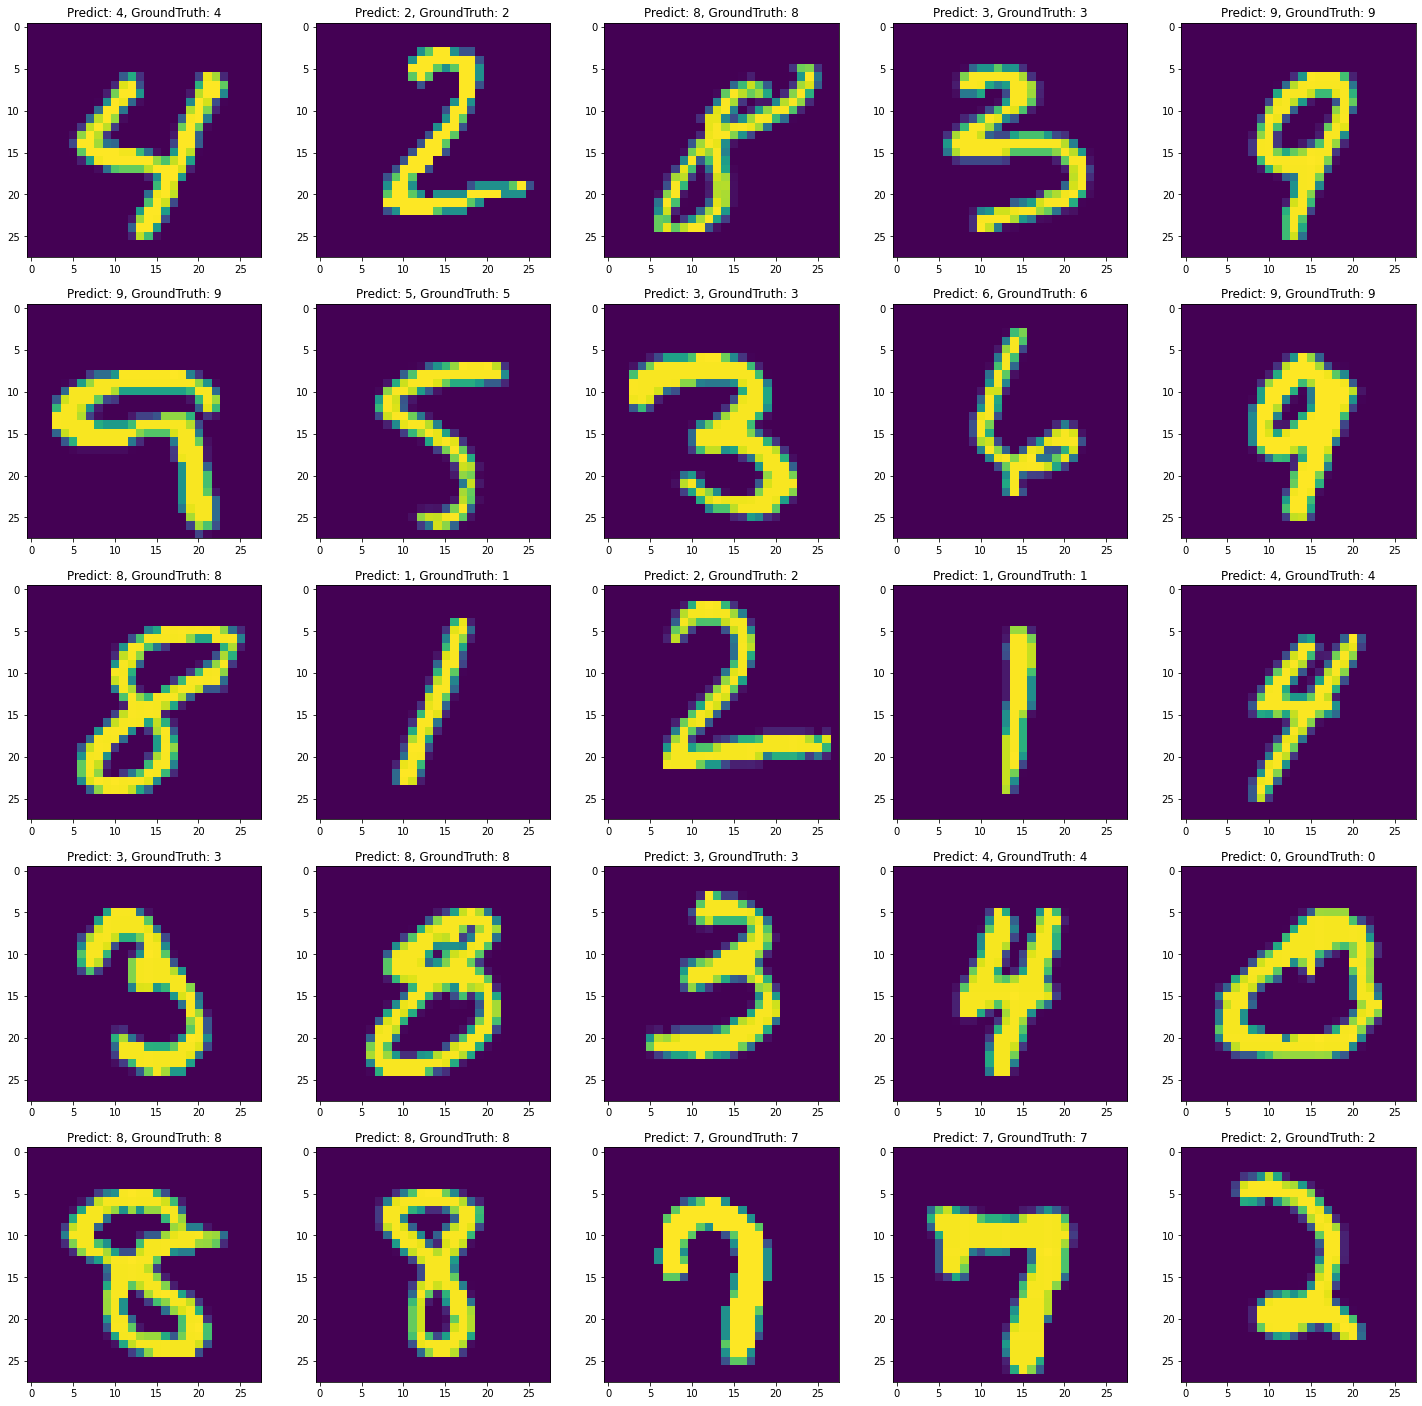

In [17]:
# network = load_model("last.pt")
show_rows = 5 # 五行
show_cols = 5 # 五列
select_count = show_rows * show_cols
select_iter = iter(test_loader)
test_batch_images, test_batch_labels, test_batch_onehots = next(select_iter)

network.eval()
predict        = network.inference(norm_image(test_batch_images))  # 进行网络预测
predict_labels = predict.argmax(axis=1)  # 获取预测的标签值

plt.figure(figsize=(show_rows * 5, show_cols * 5))  # 定义画板的大小
for i in range(select_count):  # 显示图片和标题

    plt.subplot(show_rows, show_cols, i+1)

    predict_label      = predict_labels[i]
    ground_truth_label = test_batch_labels[i, 0]
    image              = test_batch_images[i].reshape(28, 28)

    plt.title(f"Predict: {predict_label}, GroundTruth: {ground_truth_label}")
    plt.imshow(image)